# Mining complex networks

## Bogumił Kamiński

The objective of this workshop is to give an introduction to:
* Working with graph data in Julia?
* Doing simple analysis of graph properties.
* Building a prediction model for node classification task.

We will work with GitHub social network.

It is a social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them.

The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer.

See [here](http://snap.stanford.edu/data/github-social.html) for more details.

### Loading the required packages

In [1]:
using CategoricalArrays

In [2]:
using CSV

In [3]:
using DataFramesMeta

In [4]:
using GLM

In [5]:
using Graphs

In [6]:
using Plots

In [7]:
using StatsBase

In [8]:
using Statistics

### Reading in the data to a data frame

In [9]:
edges_df = CSV.read("musae_git_edges.csv", DataFrame)

Row,id_1,id_2
,Int64,Int64
1,0,23977
2,1,34526
3,1,2370
4,1,14683
5,1,29982
6,1,21142
7,1,20363
8,1,23830
9,1,34035


In [10]:
classes_df = CSV.read("musae_git_target.csv", DataFrame)

Row,id,name,ml_target
,Int64,String31,Int64
1,0,Eiryyy,0
2,1,shawflying,0
3,2,JpMCarrilho,1
4,3,SuhwanCha,0
5,4,sunilangadi2,1
6,5,j6montoya,0
7,6,sfate,0
8,7,amituuush,0
9,8,mauroherlein,0


In [11]:
describe(edges_df, :min, :max, :mean, :nmissing, :eltype)

Row,variable,min,max,mean,nmissing,eltype
,Symbol,Int64,Int64,Float64,Int64,DataType
1,id_1,0,37694,14812.6,0,Int64
2,id_2,16,37699,23778.8,0,Int64


In [12]:
describe(classes_df, :min, :max, :mean, :nmissing, :eltype)

Row,variable,min,max,mean,nmissing,eltype
,Symbol,Any,Any,Union…,Int64,DataType
1,id,0,37699,18849.5,0,Int64
2,name,007arunwilson,timqian,,0,String31
3,ml_target,0,1,0.258329,0,Int64


Note that nodes are numbered uses 0-based indexing. We will need to fix it.

In [13]:
edges_df .+= 1

Row,id_1,id_2
,Int64,Int64
1,1,23978
2,2,34527
3,2,2371
4,2,14684
5,2,29983
6,2,21143
7,2,20364
8,2,23831
9,2,34036


In [14]:
classes_df.id .+= 1

37700-element Vector{Int64}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
     ⋮
 37689
 37690
 37691
 37692
 37693
 37694
 37695
 37696
 37697
 37698
 37699
 37700

### Creating a graph using source data and its initial inspection

In [15]:
gh = SimpleGraph(nrow(classes_df))

{37700, 0} undirected simple Int64 graph

In [16]:
for (srt, dst) in eachrow(edges_df)
    add_edge!(gh, srt, dst)
end

In [17]:
gh

{37700, 289003} undirected simple Int64 graph

In [18]:
ne(gh)

289003

In [19]:
nv(gh)

37700

In [20]:
connected_components(gh)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  37691, 37692, 37693, 37694, 37695, 37696, 37697, 37698, 37699, 37700]

### Getting and analyzing node degree in the graph

In [21]:
degree(gh)

37700-element Vector{Int64}:
   1
   8
   1
   5
   2
   1
   6
   8
   8
   7
  66
   2
   6
   ⋮
   8
   9
 215
   3
  58
   4
  20
   1
   2
   4
   3
   4

In [22]:
classes_df.deg = degree(gh)

37700-element Vector{Int64}:
   1
   8
   1
   5
   2
   1
   6
   8
   8
   7
  66
   2
   6
   ⋮
   8
   9
 215
   3
  58
   4
  20
   1
   2
   4
   3
   4

In [23]:
describe(classes_df.deg)

Summary Stats:
Length:         37700
Missing Count:  0
Mean:           15.331724
Minimum:        1.000000
1st Quartile:   2.000000
Median:         6.000000
3rd Quartile:   13.000000
Maximum:        9458.000000
Type:           Int64


### Warmup task: random walk on a graph

Assume that we start in an arbitrarily picked node. Next we visit one of its neighbors (randomly picked).
Questions:
* what will be the average degree of the visited nodes in the long run?
* what will be the probability of visiting some node in the long run?

In [24]:
function travel(gh, i, steps)
    degs = [degree(gh, i)]
    visits = fill(0, nv(gh))
    visits[i] += 1
    for _ in 1:steps
        i = rand(neighbors(gh, i))
        push!(degs, degree(gh, i))
        visits[i] += 1
    end
    return degs, visits
end

travel (generic function with 1 method)

In [25]:
degs, visits = travel(gh, 1, 10^7)

([1, 32, 60, 51, 331, 30, 6, 7085, 8, 3  …  1, 613, 249, 30, 34, 29, 2468, 6, 385, 19], [21, 135, 26, 85, 38, 24, 99, 136, 140, 127  …  3782, 41, 979, 78, 354, 30, 44, 61, 43, 71])

In [26]:
mean(degs)

440.90957490904253

Surprisingly it is larger than mean degree of the node in the graph.

Let us check mean weighted by degree:

In [27]:
mean(classes_df.deg, Weights(classes_df.deg))

441.020594941921

So it looks that probability of visiting the node is proportional to its degree. Let us check it more closely:

In [28]:
cor(classes_df.deg, visits)

0.9999242236638517

In [29]:
[ones(nv(gh)) classes_df.deg] \ visits

2-element Vector{Float64}:
  0.06917795965012687
 17.29634811908733

Now instead of the simulation results let us analyze the probability of visiting the node numerically using transition matrix:

In [30]:
am = adjacency_matrix(gh)

37700×37700 SparseArrays.SparseMatrixCSC{Int64, Int64} with 578006 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠇

In [31]:
travel_prob = (1 ./ classes_df.deg)

37700-element Vector{Float64}:
 1.0
 0.125
 1.0
 0.2
 0.5
 1.0
 0.16666666666666666
 0.125
 0.125
 0.14285714285714285
 0.015151515151515152
 0.5
 0.16666666666666666
 ⋮
 0.125
 0.1111111111111111
 0.004651162790697674
 0.3333333333333333
 0.017241379310344827
 0.25
 0.05
 1.0
 0.5
 0.25
 0.3333333333333333
 0.25

In [32]:
tm = am .* travel_prob

37700×37700 SparseArrays.SparseMatrixCSC{Float64, Int64} with 578006 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇
⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠇

In [33]:
function pow_iter(tm; iters=1000)
    x = ones(1, size(tm, 2))
    for _ in 1:iters
        x = x * tm
        x ./= sum(x)
    end
    return x
end

pow_iter (generic function with 1 method)

In [34]:
stationary_prob = pow_iter(tm)

1×37700 Matrix{Float64}:
 1.73009e-6  1.38407e-5  1.73009e-6  …  6.92034e-6  5.19026e-6  6.92034e-6

In [35]:
(classes_df.deg / sum(classes_df.deg))'

1×37700 adjoint(::Vector{Float64}) with eltype Float64:
 1.73009e-6  1.38407e-5  1.73009e-6  …  6.92034e-6  5.19026e-6  6.92034e-6

In [36]:
extrema(stationary_prob - (classes_df.deg / sum(classes_df.deg))')

(-2.2065682614424986e-15, 4.0072112295064244e-16)

Why is this finding important?

### Main task: prediction of developer type by inspection of types of its neighbors

Understanding how one can inspect edges of a graph

In [37]:
edges(gh)

SimpleEdgeIter 289003

In [38]:
e1 = first(edges(gh))

Edge 1 => 23978

In [39]:
dump(e1)

Graphs.SimpleGraphs.SimpleEdge{Int64}
  src: Int64 1
  dst: Int64 23978


In [40]:
e1.src

1

In [41]:
e1.dst

23978

Counting neighbors of a node that have ml or web type:

In [42]:
function deg_class(gh, class)
    deg_ml = zeros(Int, length(class))
    deg_web = zeros(Int, length(class))
    for edge in edges(gh)
        a, b = edge.src, edge.dst
        if class[b] == 1
            deg_ml[a] += 1
        else
            deg_web[a] += 1
        end
        if class[a] == 1
            deg_ml[b] += 1
        else
            deg_web[b] += 1
        end
    end
    return (deg_ml, deg_web)
end

deg_class (generic function with 1 method)

In [43]:
classes_df.deg_ml, classes_df.deg_web = deg_class(gh, classes_df.ml_target)

([0, 0, 0, 3, 1, 0, 0, 0, 1, 2  …  2, 0, 12, 1, 0, 1, 0, 0, 1, 0], [1, 8, 1, 2, 1, 1, 6, 8, 7, 5  …  213, 3, 46, 3, 20, 0, 2, 4, 2, 4])

In [44]:
describe(classes_df, :min, :max, :mean, :std)

Row,variable,min,max,mean,std
,Symbol,Any,Any,Union…,Union…
1,id,1,37700,18850.5,10883.2
2,name,007arunwilson,timqian,,
3,ml_target,0,1,0.258329,0.437722
4,deg,1,9458,15.3317,80.7881
5,deg_ml,0,1620,2.22981,13.935
6,deg_web,0,8194,13.1019,69.9712


In [45]:
classes_df.deg_ml + classes_df.deg_web == classes_df.deg

true

Computing summary statistics of web and machine learning developer's features

In [46]:
for type in [0, 1], col in ["deg_ml", "deg_web"]
    println((type, col,
    mean(classes_df[classes_df.ml_target .== type, col])))
end

(0, "deg_ml", 1.5985122134401488)
(0, "deg_web", 16.066878866993314)
(1, "deg_ml", 4.042304138001848)
(1, "deg_web", 4.589382893520895)


In [47]:
@chain classes_df begin
    groupby(:ml_target)
    @combine(:mean_deg_ml = mean(:deg_ml),
             :mean_deg_web = mean(:deg_web))
end

Row,ml_target,mean_deg_ml,mean_deg_web
,Int64,Float64,Float64
1,0,1.59851,16.0669
2,1,4.0423,4.58938


Building a logistic regression predicting developer type

In [48]:
model = glm(@formula(ml_target~log1p(deg_ml)+log1p(deg_web)), classes_df, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

ml_target ~ 1 + :(log1p(deg_ml)) + :(log1p(deg_web))

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)      0.30205   0.0288865   10.46    <1e-24   0.245433   0.358666
log1p(deg_ml)    1.80476   0.0224022   80.56    <1e-99   1.76085    1.84866
log1p(deg_web)  -1.63877   0.0208776  -78.49    <1e-99  -1.67969   -1.59785
────────────────────────────────────────────────────────────────────────────

Analysis of the quality of the created model

In [49]:
classes_df.predict = predict(model)

37700-element Vector{Float64}:
 0.30282965454640626
 0.03561591796250178
 0.30282965454640626
 0.7317659512169469
 0.6027897836494603
 0.30282965454640626
 0.05280744087342835
 0.03561591796250178
 0.1353202034881714
 0.34265057019151657
 0.18662022876084552
 0.18267568923788643
 0.05280744087342835
 ⋮
 0.46697108544462856
 0.1142814697999301
 0.0014880120492772983
 0.12241375789416
 0.20127440994462992
 0.3276559037219484
 0.00912813620140297
 0.8253483333089029
 0.18267568923788643
 0.088229291403207
 0.43847305835201505
 0.088229291403207

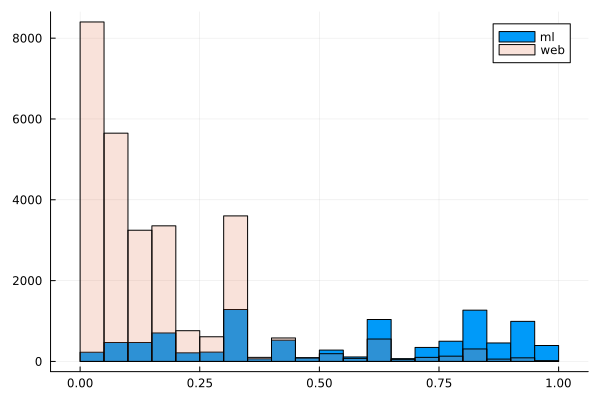

In [50]:
histogram(classes_df.predict[classes_df.ml_target .== 1], label="ml", bins=20)
histogram!(classes_df.predict[classes_df.ml_target .== 0], label="web", bins=20, fillalpha=0.2)

In [51]:
classes_df.decile = cut(classes_df.predict, 10)

37700-element CategoricalArray{String,1,UInt32}:
 "Q8: [0.30282965454640626, 0.43847305835201505)"
 "Q2: [0.01981477894510248, 0.042873665800867065)"
 "Q8: [0.30282965454640626, 0.43847305835201505)"
 "Q9: [0.43847305835201505, 0.7643080643519612)"
 "Q9: [0.43847305835201505, 0.7643080643519612)"
 "Q8: [0.30282965454640626, 0.43847305835201505)"
 "Q3: [0.042873665800867065, 0.06696749306132144)"
 "Q2: [0.01981477894510248, 0.042873665800867065)"
 "Q5: [0.1142814697999301, 0.16302534515991868)"
 "Q8: [0.30282965454640626, 0.43847305835201505)"
 "Q6: [0.16302534515991868, 0.20048425275997656)"
 "Q6: [0.16302534515991868, 0.20048425275997656)"
 "Q3: [0.042873665800867065, 0.06696749306132144)"
 ⋮
 "Q9: [0.43847305835201505, 0.7643080643519612)"
 "Q5: [0.1142814697999301, 0.16302534515991868)"
 "Q1: [0.00010832236011656448, 0.01981477894510248)"
 "Q5: [0.1142814697999301, 0.16302534515991868)"
 "Q7: [0.20048425275997656, 0.30282965454640626)"
 "Q8: [0.30282965454640626, 0.43847305835201505

In [52]:
diagnostic = @chain classes_df begin
    groupby(:decile)
    @combine(:prob_ml = mean(:ml_target), :prob_pred_ml = mean(:predict))
end

Row,decile,prob_ml,prob_pred_ml
,Cat…,Float64,Float64
1,"Q1: [0.00010832236011656448, 0.01981477894510248)",0.0115127,0.00998673
2,"Q2: [0.01981477894510248, 0.042873665800867065)",0.0335516,0.0291336
3,"Q3: [0.042873665800867065, 0.06696749306132144)",0.0553554,0.0506897
4,"Q4: [0.06696749306132144, 0.1142814697999301)",0.0845727,0.081349
5,"Q5: [0.1142814697999301, 0.16302534515991868)",0.130256,0.125422
6,"Q6: [0.16302534515991868, 0.20048425275997656)",0.173381,0.1807
7,"Q7: [0.20048425275997656, 0.30282965454640626)",0.244493,0.237877
8,"Q8: [0.30282965454640626, 0.43847305835201505)",0.280184,0.316515
9,"Q9: [0.43847305835201505, 0.7643080643519612)",0.635382,0.591563


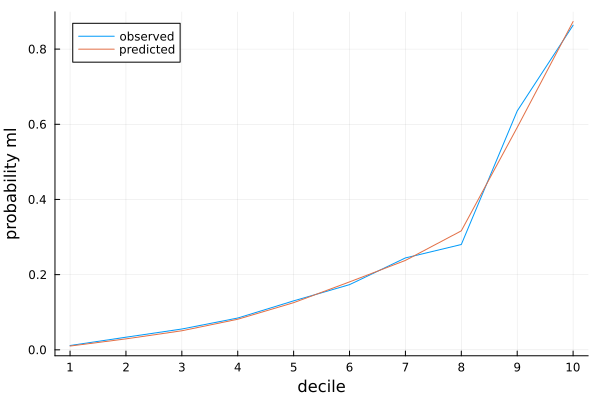

In [53]:
plot(diagnostic.prob_ml, label="observed", xticks=1:10, xlabel="decile", ylabel="probability ml")
plot!(diagnostic.prob_pred_ml, label="predicted")

*Preparation of this worksop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](logo.png)